# GEOG606 - Final Project
#### Zachary Burnett 2022-04-12

In [437]:
from datetime import datetime
from pathlib import Path

import numpy
import pandas
from stormevents import StormEvent
import geopandas
import xarray
from geopandas import GeoDataFrame, GeoSeries
from matplotlib import pyplot
from cartopy import crs
from stormevents.coops import COOPS_Station, coops_stations

In [438]:
data_directory = Path() / 'data'

#### retrieve NaturalEarth country boundaries

In [439]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

## NOAA CO-OPS water level stations

In [440]:
stations = coops_stations(station_status='active')
stations

,nws_id,name,state,status,removed,geometry
nos_id,,,,,,
1600012,46125,QREB buoy,,active,<NA>,POINT (122.62500 37.75000)
1619910,SNDP5,"Sand Island, Midway Islands",,active,<NA>,POINT (-177.37500 28.21875)
1630000,APRP7,"Apra Harbor, Guam",,active,<NA>,POINT (144.62500 13.44531)
1631428,PGBP7,"Pago Bay, Guam",,active,<NA>,POINT (144.75000 13.42969)
1770000,NSTP6,"Pago Pago, American Samoa",,active,<NA>,POINT (-170.75000 -14.27344)
...,...,...,...,...,...,...
8729840,PCLF1,Pensacola,FL,active,"2022-04-01 10:00:00,2022-04-01 00:00:00,2020-0...",POINT (-87.18750 30.40625)
8775132,LQAT2,La Quinta Channel North,TX,active,"2022-04-04 00:00:00,2022-02-18 00:00:00,2022-0...",POINT (-97.25000 27.87500)
8735180,DILA1,Dauphin Island,AL,active,"2022-04-11 23:58:00,2019-07-18 10:00:00,2018-0...",POINT (-88.06250 30.25000)


Text(0.5, 1.0, 'active NOAA CO-OPS sensor stations as of 2022-05-03')

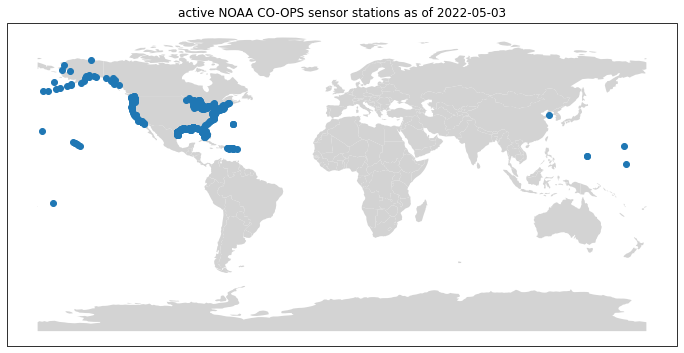

In [441]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
stations.plot(ax=axis)
axis.set_title(f'active NOAA CO-OPS sensor stations as of {datetime.now():%Y-%m-%d}')

## Hurricane Florence (2018)

In [442]:
storm = StormEvent('florence', 2018)
storm

StormEvent(name='FLORENCE', year=2018, start_date=Timestamp('2018-08-30 06:00:00'), end_date=Timestamp('2018-09-18 12:00:00'))

In [443]:
best_track = storm.track(advisories=['BEST'])
best_track

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


VortexTrack('AL062018', Timestamp('2018-08-30 06:00:00'), Timestamp('2018-09-18 12:00:00'), <ATCF_FileDeck.BEST: 'b'>, [<ATCF_Advisory.BEST: 'BEST'>], None)

In [444]:
track_bounds = numpy.stack([
    best_track.data[['longitude', 'latitude']].min().values,
    best_track.data[['longitude', 'latitude']].max().values,
], axis=1)
track_bounds[:, 0] -= 1
track_bounds[:, 1] += 1

In [445]:
wind_swath_34kt = best_track.wind_swaths(wind_speed=34)['BEST']['20180830T060000']

Text(0.5, 1.0, 'Hurricane Florence (2018)')

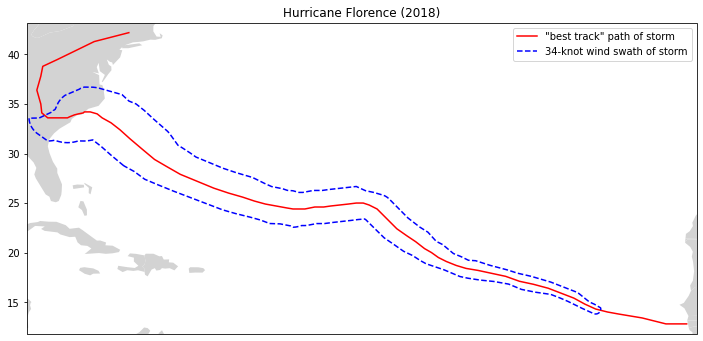

In [446]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*track_bounds[0, :])
axis.set_ylim(*track_bounds[1, :])

best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')

axis.legend()
axis.set_title('Hurricane Florence (2018)')

### load water level data modeled by the ADCIRC oceanic circulation model during Hurricane Florence (2018) within a 34-knot wind swath of the storm's path

In [447]:
filename = data_directory / 'run_20220502_florence2018_coopsstations' / 'runs' / 'unperturbed' / 'fort.61.nc'
modeled_water_levels = xarray.open_dataset(filename, drop_variables=['neta', 'nvel', 'max_nvdll', 'max_nvell'])
modeled_water_levels['station_name'] = modeled_water_levels['station_name'].astype(str).astype(int)
modeled_water_levels

<xarray.Dataset>
Dimensions:       (time: 1440, station: 164)
Coordinates:
  * time          (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06...
Dimensions without coordinates: station
Data variables:
    station_name  (station) int64 8726412 8726679 8726694 ... 8423898 8726667
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [448]:
modeled_water_levels = modeled_water_levels.rename({
    'station_name': 'nos_id',
})
modeled_water_levels = modeled_water_levels.assign_coords({
    'station': modeled_water_levels['nos_id'],
    'x': modeled_water_levels['x'],
    'y': modeled_water_levels['y'],
})
modeled_water_levels = modeled_water_levels.drop(['nos_id'])
modeled_water_levels = modeled_water_levels.rename({
    'station': 'nos_id',
})
modeled_water_levels

<xarray.Dataset>
Dimensions:  (time: 1440, nos_id: 164)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -82.62 -82.44 -82.44 ... -81.56 -70.69 -82.44
    y        (nos_id) float64 27.66 27.92 27.94 42.31 ... 35.22 29.8 43.06 27.91
  * nos_id   (nos_id) int64 8726412 8726679 8726694 ... 8720625 8423898 8726667
Data variables:
    zeta     (time, nos_id) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [449]:
modeled_water_levels['zeta']

<xarray.DataArray 'zeta' (time: 1440, nos_id: 164)>
[236160 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -82.62 -82.44 -82.44 ... -81.56 -70.69 -82.44
    y        (nos_id) float64 27.66 27.92 27.94 42.31 ... 35.22 29.8 43.06 27.91
  * nos_id   (nos_id) int64 8726412 8726679 8726694 ... 8720625 8423898 8726667
Attributes:
    long_name:      water surface elevation above geoid
    standard_name:  sea_surface_height_above_geoid
    units:          m

In [450]:
stations_bounds = numpy.array([
    [modeled_water_levels['x'].min(), modeled_water_levels['x'].max()],
    [modeled_water_levels['y'].min(), modeled_water_levels['y'].max()],
])
stations_bounds[:, 0] -= 1
stations_bounds[:, 1] += 1
stations_bounds

array([[-84.875   , -66.      ],
       [ 24.734375,  45.90625 ]])

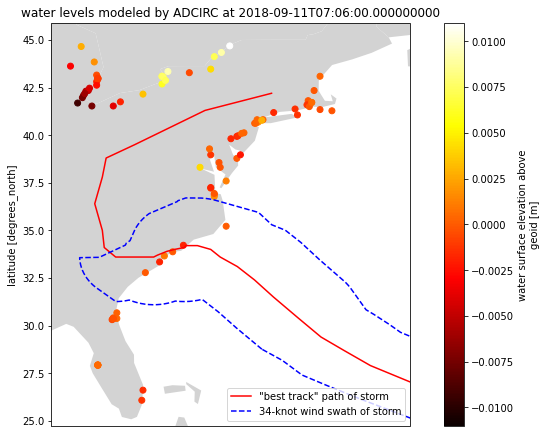

In [451]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

modeled_water_levels_at_selected_time = modeled_water_levels.isel(time=10)
modeled_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='zeta', cmap='hot', ax=axis)
axis.set_title(f'water levels modeled by ADCIRC at {modeled_water_levels_at_selected_time["time"].values}')

axis.legend()

### retrieve water level data observed by NOAA CO-OPS during Hurricane Florence (2018) within the 34-knot isotach of the storm

In [452]:
observed_water_levels_filename = data_directory / 'florence2018_east_coast_water_levels.nc'

if not observed_water_levels_filename.exists():
    stations = [
        COOPS_Station(float(nos_id.values))
        for nos_id in modeled_water_levels['nos_id']
    ]
    data = [
        station.product(
            'water_level',
            start_date=pandas.to_datetime(min(modeled_water_levels['time']).values),
            end_date=pandas.to_datetime(max(modeled_water_levels['time']).values),
            units='metric',
        )
        for station in stations
    ]
    data = [
        entry for entry in data
        if numpy.product(list(entry.sizes.values())) > 0
    ]
    observed_water_levels = xarray.combine_by_coords(data)
    observed_water_levels.to_netcdf(observed_water_levels_filename)
else:
    observed_water_levels = xarray.open_dataset(observed_water_levels_filename)

observed_water_levels = observed_water_levels.rename({'t': 'time'})

observed_water_levels

<xarray.Dataset>
Dimensions:  (time: 1440, nos_id: 111)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object ...
    x        (nos_id) float64 ...
    y        (nos_id) float64 ...
Data variables:
    v        (nos_id, time) float32 ...
    s        (nos_id, time) float32 ...
    f        (nos_id, time) object ...
    q        (nos_id, time) object ...

In [453]:
observed_water_levels['v']

<xarray.DataArray 'v' (nos_id: 111, time: 1440)>
[159840 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### normalize observed water levels by subtracting the time average for each station

In [454]:
observed_water_levels['normalized_v'] = observed_water_levels['v'] - observed_water_levels['v'].mean(dim='time')
observed_water_levels['normalized_v']

<xarray.DataArray 'normalized_v' (nos_id: 111, time: 1440)>
array([[-1.9378662e-02, -2.1377563e-02, -2.2377014e-02, ...,
        -1.5373230e-02, -1.6372681e-02, -1.5373230e-02],
       [ 1.2893677e-02,  1.3893127e-02,  1.5892029e-02, ...,
        -4.1046143e-03, -5.1040649e-03, -1.1062622e-03],
       [ 2.3347917e+00,  2.2027917e+00,  2.0687914e+00, ...,
        -7.5820851e-01, -6.3920832e-01, -5.2420831e-01],
       ...,
       [-1.1413574e-02, -4.1198730e-04,  1.4587402e-02, ...,
        -2.8411865e-02, -4.3411255e-02, -4.2419434e-02],
       [-5.9204102e-03, -1.3916016e-02, -4.9133301e-03, ...,
        -2.9922485e-02, -6.9122314e-03, -9.9182129e-03],
       [ 1.5792847e-02,  1.4785767e-02,  1.5792847e-02, ...,
        -5.6213379e-02, -5.9204102e-02, -6.4208984e-02]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### compare modeled water levels vs observed water levels

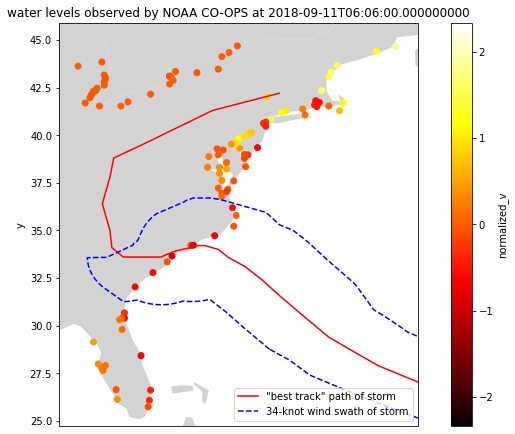

In [455]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

observed_water_levels_at_selected_time = observed_water_levels.isel(time=0)
observed_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='normalized_v', cmap='hot', ax=axis)
axis.set_title(f'water levels observed by NOAA CO-OPS at {observed_water_levels_at_selected_time["time"].values}')

axis.legend()

Text(0.5, 1.0, 'water levels observed by NOAA CO-OPS at each station')

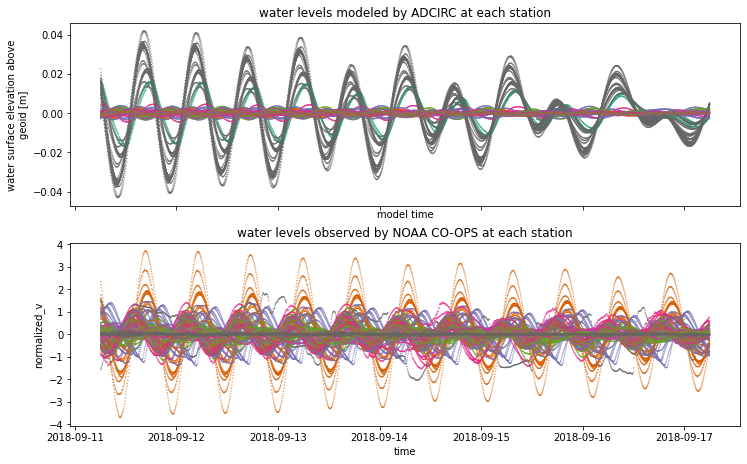

In [456]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis_1, axis_2 = figure.subplots(2, 1, sharex='all')

modeled_water_levels.plot.scatter(x='time', y='zeta', hue='nos_id', cmap='Dark2', add_guide=False, s=0.1, ax=axis_1)
observed_water_levels.plot.scatter(x='time', y='normalized_v', hue='nos_id', cmap='Dark2', add_guide=False, s=0.1, ax=axis_2)

axis_1.set_title('water levels modeled by ADCIRC at each station')
axis_2.set_title('water levels observed by NOAA CO-OPS at each station')

In [457]:
rmse = ((modeled_water_levels['zeta'] - observed_water_levels['normalized_v']) ** 2).mean(dim='time') ** 0.5
rmse = rmse.assign_coords({'x': modeled_water_levels['x'], 'y':modeled_water_levels['y']})
rmse

<xarray.DataArray (nos_id: 111)>
array([0.02128197, 0.04210977, 0.0205966 , 0.03218496, 0.01950455,
       0.02247561, 0.0103196 , 0.01961302, 0.08258999, 0.01432734,
       0.02042943, 0.96237612, 0.03894802, 0.53253164, 0.02300121,
              nan,        nan, 0.02319296, 0.77586908, 0.01643437,
              nan,        nan, 0.09537138, 0.02163444, 0.01875103,
              nan, 0.02355351,        nan, 0.4929015 , 0.61857875,
              nan, 0.13660356, 0.21030031, 0.03242262, 0.01732555,
              nan, 0.54119542, 0.45901276,        nan,        nan,
       0.43896382,        nan, 0.20687485, 0.64806037, 0.27143278,
              nan,        nan,        nan, 0.69149218,        nan,
              nan, 0.33302494,        nan, 0.57726255,        nan,
       0.29204984,        nan, 0.23917263,        nan, 1.13744293,
              nan,        nan, 0.64463479,        nan,        nan,
       0.41447346,        nan, 0.02528413, 0.01874428, 0.54355121,
       0.04450014, 0.16152166, 0.37940142,        nan,        nan,
              nan,        nan, 0.30461755, 0.81897383,        nan,
              nan, 0.02032789, 0.03693818, 0.66972972, 0.58694636,
              nan, 0.49224292,        nan,        nan, 0.23882982,
       0.02833552,        nan, 0.75926685, 0.62930133, 0.01110024,
              nan, 0.433791  ,        nan,        nan, 0.32674324,
       0.02757738, 0.23385463,        nan, 0.9151804 , 0.29270237,
       0.01369559,        nan,        nan,        nan,        nan,
              nan])
Coordinates:
  * nos_id   (nos_id) int64 9044036 9075035 9052076 ... 8720625 8423898 8726667
    nws_id   (nos_id) object 'FWNM4' 'ESVM4' 'OCTN6' ... 'RCYF1' 'FTPN3' 'MCYF1'
    y        (nos_id) float64 42.31 43.62 43.34 42.09 ... 37.03 29.8 43.06 27.91
    x        (nos_id) float64 -83.06 -83.88 -78.75 ... -81.56 -70.69 -82.44

<AxesSubplot:xlabel='nos_id'>

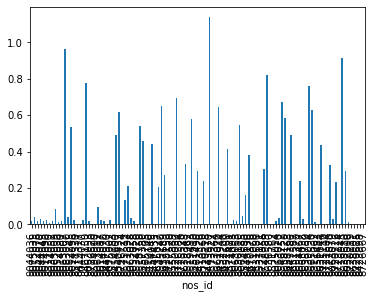

In [458]:
rmse.to_series().plot.bar()

## calculate spatial auto-correlation of the RMSE values

In [459]:
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
from shapely.geometry import Polygon, MultiPoint

### build Voronoi regions from points

In [460]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [461]:
voronoi_regions = Voronoi(numpy.stack([rmse['x'], rmse['y']], axis=1))
voronoi_regions

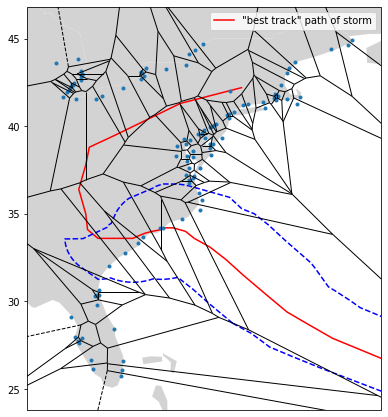

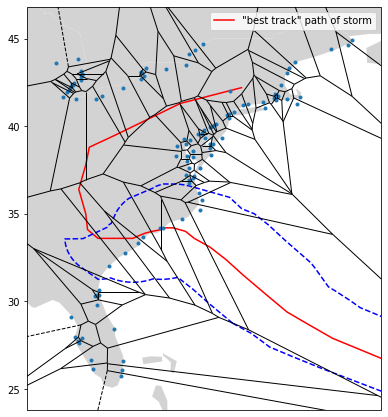

In [462]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

voronoi_plot_2d(
    voronoi_regions,
    color='darkgrey',
    show_points=True,
    show_vertices=False,
    ax=axis,
)

### attach these voronoi regions to the RMSE dataset

In [463]:
polygons = {}
for region_index, region in enumerate(voronoi_regions.regions):
    if region_index in voronoi_regions.point_region:
        point_indices = voronoi_regions.point_region[voronoi_regions.point_region == region_index]
        points = voronoi_regions.points[[index for index in point_indices if index != -1]]
        point = points[0, :]
        entry = rmse.where(
            (rmse['x'] == point[0]) &
            (rmse['y'] == point[1]),
            drop=True,
        )
        polygon = Polygon([voronoi_regions.vertices[vertex_index] for vertex_index in region if vertex_index != -1])
        polygons[int(entry['nos_id'][0].values)] = polygon
polygons = GeoSeries(polygons)
polygons

9044036    POLYGON ((-71.484 53.896, 157.097 -123.362, -6...
9075035    POLYGON ((-80.959 26.446, -65.503 24.627, -60....
9052076    POLYGON ((-80.970 26.054, 157.097 -123.362, -7...
9044020    POLYGON ((-66.982 41.707, -67.901 45.387, -71....
9044049    POLYGON ((-66.982 41.707, -67.901 45.387, 157....
                                 ...                        
9052000    POLYGON ((-76.259 37.176, -76.734 36.859, -76....
8720219    POLYGON ((-75.895 36.614, -76.757 35.797, -77....
8638901    POLYGON ((-75.895 36.614, -76.757 35.797, -76....
8720625    POLYGON ((-76.248 37.202, -76.231 37.341, -76....
8423898    POLYGON ((-76.259 37.176, -76.734 36.859, -78....
Length: 107, dtype: geometry

In [464]:
rmse_dataframe = rmse.to_dataframe(name='rmse')
rmse_dataframe = GeoDataFrame(rmse_dataframe, geometry=geopandas.points_from_xy(rmse_dataframe['x'], rmse_dataframe['y']))
rmse_dataframe

,nws_id,y,x,rmse,geometry
nos_id,,,,,
9044036,FWNM4,42.312500,-83.0625,0.021282,POINT (-83.06250 42.31250)
9075035,ESVM4,43.625000,-83.8750,0.042110,POINT (-83.87500 43.62500)
9052076,OCTN6,43.343750,-78.7500,0.020597,POINT (-78.75000 43.34375)
9044020,GRTM4,42.093750,-83.1875,0.032185,POINT (-83.18750 42.09375)
9044049,WMPM4,42.343750,-82.9375,0.019505,POINT (-82.93750 42.34375)
...,...,...,...,...,...
8720219,DMSF1,30.390625,-81.5625,NaN,POINT (-81.56250 30.39063)
8638901,CHBV2,37.031250,-76.0625,NaN,POINT (-76.06250 37.03125)
8720625,RCYF1,29.796875,-81.5625,NaN,POINT (-81.56250 29.79688)


In [465]:
rmse_dataframe['region'] = polygons
rmse_dataframe

,nws_id,y,x,rmse,geometry,region
nos_id,,,,,,
9044036,FWNM4,42.312500,-83.0625,0.021282,POINT (-83.06250 42.31250),"POLYGON ((-71.484 53.896, 157.097 -123.362, -6..."
9075035,ESVM4,43.625000,-83.8750,0.042110,POINT (-83.87500 43.62500),"POLYGON ((-80.959 26.446, -65.503 24.627, -60...."
9052076,OCTN6,43.343750,-78.7500,0.020597,POINT (-78.75000 43.34375),"POLYGON ((-80.970 26.054, 157.097 -123.362, -7..."
9044020,GRTM4,42.093750,-83.1875,0.032185,POINT (-83.18750 42.09375),"POLYGON ((-66.982 41.707, -67.901 45.387, -71...."
9044049,WMPM4,42.343750,-82.9375,0.019505,POINT (-82.93750 42.34375),"POLYGON ((-66.982 41.707, -67.901 45.387, 157...."
...,...,...,...,...,...,...
8720219,DMSF1,30.390625,-81.5625,NaN,POINT (-81.56250 30.39063),"POLYGON ((-75.895 36.614, -76.757 35.797, -77...."
8638901,CHBV2,37.031250,-76.0625,NaN,POINT (-76.06250 37.03125),"POLYGON ((-75.895 36.614, -76.757 35.797, -76...."
8720625,RCYF1,29.796875,-81.5625,NaN,POINT (-81.56250 29.79688),"POLYGON ((-76.248 37.202, -76.231 37.341, -76...."


In [466]:
rmse_dataframe['point'] = rmse_dataframe['geometry']
rmse_dataframe

,nws_id,y,x,rmse,geometry,region,point
nos_id,,,,,,,
9044036,FWNM4,42.312500,-83.0625,0.021282,POINT (-83.06250 42.31250),"POLYGON ((-71.484 53.896, 157.097 -123.362, -6...",POINT (-83.06250 42.31250)
9075035,ESVM4,43.625000,-83.8750,0.042110,POINT (-83.87500 43.62500),"POLYGON ((-80.959 26.446, -65.503 24.627, -60....",POINT (-83.87500 43.62500)
9052076,OCTN6,43.343750,-78.7500,0.020597,POINT (-78.75000 43.34375),"POLYGON ((-80.970 26.054, 157.097 -123.362, -7...",POINT (-78.75000 43.34375)
9044020,GRTM4,42.093750,-83.1875,0.032185,POINT (-83.18750 42.09375),"POLYGON ((-66.982 41.707, -67.901 45.387, -71....",POINT (-83.18750 42.09375)
9044049,WMPM4,42.343750,-82.9375,0.019505,POINT (-82.93750 42.34375),"POLYGON ((-66.982 41.707, -67.901 45.387, 157....",POINT (-82.93750 42.34375)
...,...,...,...,...,...,...,...
8720219,DMSF1,30.390625,-81.5625,NaN,POINT (-81.56250 30.39063),"POLYGON ((-75.895 36.614, -76.757 35.797, -77....",POINT (-81.56250 30.39063)
8638901,CHBV2,37.031250,-76.0625,NaN,POINT (-76.06250 37.03125),"POLYGON ((-75.895 36.614, -76.757 35.797, -76....",POINT (-76.06250 37.03125)
8720625,RCYF1,29.796875,-81.5625,NaN,POINT (-81.56250 29.79688),"POLYGON ((-76.248 37.202, -76.231 37.341, -76....",POINT (-81.56250 29.79688)


In [467]:
rmse_dataframe = GeoDataFrame(
    rmse_dataframe,
    geometry=rmse_dataframe['region'],
)
rmse_dataframe

,nws_id,y,x,rmse,geometry,region,point
nos_id,,,,,,,
9044036,FWNM4,42.312500,-83.0625,0.021282,"POLYGON ((-71.484 53.896, 157.097 -123.362, -6...","POLYGON ((-71.484 53.896, 157.097 -123.362, -6...",POINT (-83.06250 42.31250)
9075035,ESVM4,43.625000,-83.8750,0.042110,"POLYGON ((-80.959 26.446, -65.503 24.627, -60....","POLYGON ((-80.959 26.446, -65.503 24.627, -60....",POINT (-83.87500 43.62500)
9052076,OCTN6,43.343750,-78.7500,0.020597,"POLYGON ((-80.970 26.054, 157.097 -123.362, -7...","POLYGON ((-80.970 26.054, 157.097 -123.362, -7...",POINT (-78.75000 43.34375)
9044020,GRTM4,42.093750,-83.1875,0.032185,"POLYGON ((-66.982 41.707, -67.901 45.387, -71....","POLYGON ((-66.982 41.707, -67.901 45.387, -71....",POINT (-83.18750 42.09375)
9044049,WMPM4,42.343750,-82.9375,0.019505,"POLYGON ((-66.982 41.707, -67.901 45.387, 157....","POLYGON ((-66.982 41.707, -67.901 45.387, 157....",POINT (-82.93750 42.34375)
...,...,...,...,...,...,...,...
8720219,DMSF1,30.390625,-81.5625,NaN,"POLYGON ((-75.895 36.614, -76.757 35.797, -77....","POLYGON ((-75.895 36.614, -76.757 35.797, -77....",POINT (-81.56250 30.39063)
8638901,CHBV2,37.031250,-76.0625,NaN,"POLYGON ((-75.895 36.614, -76.757 35.797, -76....","POLYGON ((-75.895 36.614, -76.757 35.797, -76....",POINT (-76.06250 37.03125)
8720625,RCYF1,29.796875,-81.5625,NaN,"POLYGON ((-76.248 37.202, -76.231 37.341, -76....","POLYGON ((-76.248 37.202, -76.231 37.341, -76....",POINT (-81.56250 29.79688)


In [468]:
rmse_dataframe = rmse_dataframe.clip(
    MultiPoint(rmse_dataframe['point'].tolist()).convex_hull,
)
rmse_dataframe

,nws_id,y,x,rmse,geometry,region,point
nos_id,,,,,,,
9052076,OCTN6,43.34375,-78.7500,0.020597,"POLYGON ((-80.97007 26.05422, -80.07894 25.892...","POLYGON ((-80.970 26.054, 157.097 -123.362, -7...",POINT (-78.75000 43.34375)
9044049,WMPM4,42.34375,-82.9375,0.019505,"POLYGON ((-67.77626 44.88627, -67.25178 44.899...","POLYGON ((-66.982 41.707, -67.901 45.387, 157....",POINT (-82.93750 42.34375)
9044036,FWNM4,42.31250,-83.0625,0.021282,"POLYGON ((-67.25178 44.89977, -67.00000 44.906...","POLYGON ((-71.484 53.896, 157.097 -123.362, -6...",POINT (-83.06250 42.31250)
8670870,FPKG1,32.03125,-80.8750,NaN,"POLYGON ((-70.92002 40.25026, -70.31361 41.614...","POLYGON ((-70.430 36.193, -70.400 36.125, -70....",POINT (-80.87500 32.03125)
9075035,ESVM4,43.62500,-83.8750,0.042110,"POLYGON ((-79.79270 26.30833, -80.07894 25.892...","POLYGON ((-80.959 26.446, -65.503 24.627, -60....",POINT (-83.87500 43.62500)
...,...,...,...,...,...,...,...
8551910,RDYD1,39.56250,-75.5625,NaN,"POLYGON ((-83.00260 42.98438, -82.70312 42.984...","POLYGON ((-82.759 42.719, -83.003 42.984, -82....",POINT (-75.56250 39.56250)
8510560,MTKN6,41.06250,-71.9375,0.239173,"POLYGON ((-82.70312 42.98438, -81.20230 42.984...","POLYGON ((-82.625 42.953, -81.234 42.953, -81....",POINT (-71.93750 41.06250)
8573927,CHCM2,39.53125,-75.8125,NaN,"POLYGON ((-80.84107 43.72920, -81.05645 43.122...","POLYGON ((-82.703 42.984, -80.841 43.729, -81....",POINT (-75.81250 39.53125)


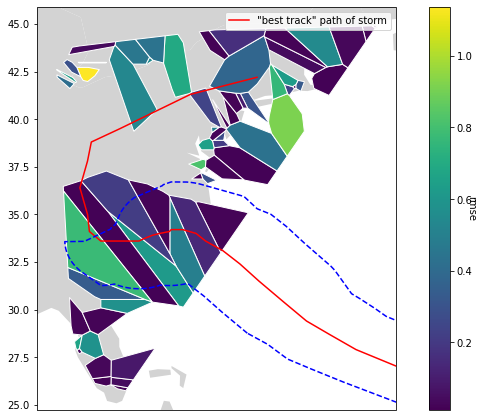

In [469]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='rmse', edgecolor='white', ax=axis)

colorbar = pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['rmse'].min(),
        vmax=rmse_dataframe['rmse'].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)
colorbar.set_label('rmse', rotation=270)

### univariate spatial auto-correlation

In [470]:
from libpysal.weights import Queen, Rook
from esda.moran import Moran
from splot.esda import plot_moran

geopandas.options.use_pygeos = True

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


#### rook connectivity

In [471]:
rook_weights = Rook.from_dataframe(rmse_dataframe)

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise

(<Figure size 864x533.981 with 1 Axes>, <GeoAxesSubplot:xlabel='longitude'>)

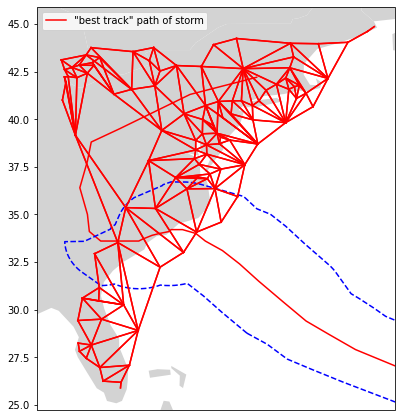

In [472]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rook_weights.plot(
    rmse_dataframe.reset_index(),
    edge_kws=dict(color='r'),
    node_kws=dict(marker=''),
    ax=axis,
)

#### global Moran's I

In [473]:
rook_morans_i = Moran(
    rmse_dataframe[['rmse']].values,
    rook_weights,
)
rook_morans_i.I

nan

In [474]:
%%script false --no-raise-error
plot_moran(
    rook_morans_i,
    zstandard=True,
    figsize=(12, 12 / 1.61803398875),
)

In [475]:
rook_morans_i.p_sim

0.001

#### queen connectivity

In [476]:
queen_weights = Queen.from_dataframe(rmse_dataframe)

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise

(<Figure size 864x533.981 with 1 Axes>, <GeoAxesSubplot:xlabel='longitude'>)

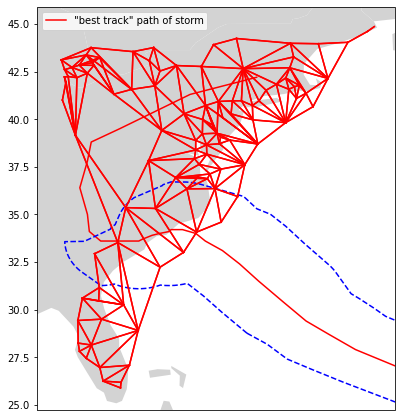

In [477]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, projection=crs.Robinson())

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

queen_weights.plot(
    rmse_dataframe.reset_index(),
    edge_kws=dict(color='r'),
    node_kws=dict(marker=''),
    ax=axis,
)

#### global Moran's I

In [478]:
queen_morans_i = Moran(
    rmse_dataframe[['rmse']].values,
    queen_weights,
)
queen_morans_i.I

nan

In [479]:
%%script false --no-raise-error
plot_moran(
    queen_morans_i,
    zstandard=True,
    figsize=(12, 12 / 1.61803398875),
)

In [480]:
queen_morans_i.p_sim

0.001